In [63]:
import os
import math
# import torch
import datetime
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

from torch import nn
# from spacy.lang.en import English
from torchvision import transforms
from torchvision.models import inception_v3
from torch.utils.data import Dataset, DataLoader
import pandas as pd

import cv2
import torchvision.models as models
import torch.optim as optim
from efficientnet_pytorch import EfficientNet

from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [64]:
ds_path = '../CUB/CUB_200_2011/'
seg_path = '../CUB/segmentations/'

In [65]:
images = {'id':[], 'path_i':[], 'path_m':[]}

with open(ds_path+'images.txt', 'r') as f : 
    lines = f.readlines()
    for l in lines : 
        l = l.strip().split(' ')
        images['id'].append(int(l[0]))
        images['path_i'].append(l[1])
        images['path_m'].append(l[1][:-4]+'.png')
        
images = pd.DataFrame(images)
images.head()

,id,path_i,path_m
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross/Black_Footed_Albatr...
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross/Black_Footed_Albatr...
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross/Black_Footed_Albatr...
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,001.Black_footed_Albatross/Black_Footed_Albatr...


In [66]:
bd_boxes = {'id':[], 'x':[], 'y':[], 'width':[], 'height':[]}

with open(ds_path+'bounding_boxes.txt', 'r') as f : 
    lines = f.readlines()
    for l in lines : 
        l = l.strip().split(' ')
        bd_boxes['id'].append(float(l[0]))
        bd_boxes['x'].append(float(l[1]))
        bd_boxes['y'].append(float(l[2]))
        bd_boxes['width'].append(float(l[3]))
        bd_boxes['height'].append(float(l[4]))
        
bd_boxes = pd.DataFrame(bd_boxes)
bd_boxes['id'] = bd_boxes['id'].astype(int)
bd_boxes.head()

,id,x,y,width,height
0,1,60.0,27.0,325.0,304.0
1,2,139.0,30.0,153.0,264.0
2,3,14.0,112.0,388.0,186.0
3,4,112.0,90.0,255.0,242.0
4,5,70.0,50.0,134.0,303.0


In [67]:
part_locs = {1:{}}

with open(ds_path+'/parts/'+'part_locs.txt', 'r') as f : 
    lines = f.readlines()
    parts = {'part_id':[], 'x':[], 'y':[]}
    i = 0 
    while i<len(lines) :
        l = lines[i].strip().split(' ')
        if int(l[0]) not in part_locs : 
            part_locs[int(l[0])-1] = pd.DataFrame(parts)
            part_locs[int(l[0])] = {}
            parts = {'part_id':[], 'x':[], 'y':[]}
        # print(l)
        parts['part_id'].append(int(l[1]))
        
        parts['x'].append(float(l[2]))
        parts['y'].append(float(l[3]))
        i +=1 
    part_locs[len(part_locs)] = pd.DataFrame(parts)

Visualization 

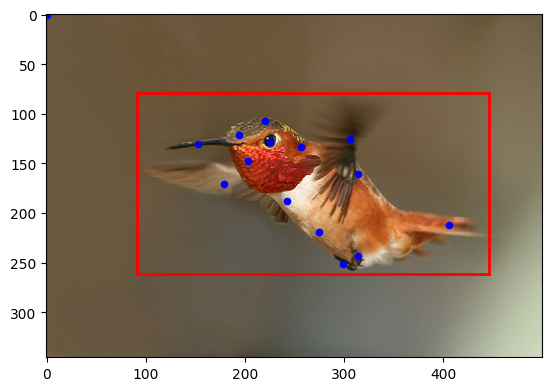

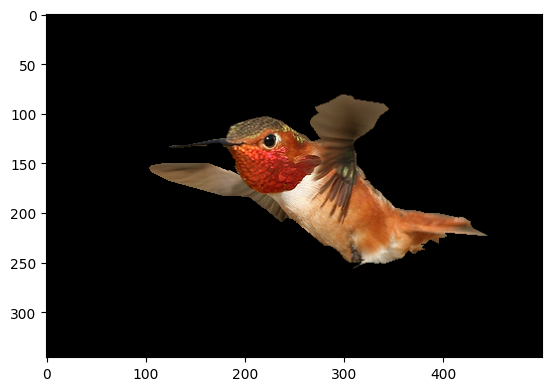

In [68]:
i = 4000

p0 = images.iloc[i, 1]
im = plt.imread(ds_path+'images/'+p0)
mask = plt.imread(seg_path+p0[:-4]+'.png')

x, y, w, h = bd_boxes.iloc[i, 1:]

parts = part_locs[i+1]

plt.imshow(im)

plt.scatter(parts['x'], parts['y'], c='b', s=20)

bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(bbox)
plt.show()

plt.show()
plt.imshow(im*np.transpose(np.array([mask for _ in range(3)]), (1, 2, 0)).astype(int))
plt.show()

In [69]:
class_names = {}

with open(ds_path+'classes.txt', 'r') as f : 
    lines = f.readlines()
    for line in lines : 
        line = line.strip().split(' ') 
        class_names[line[1]] = int(line[0])

In [70]:
ds_images = []
# ds_mask_images = []
ds_parts = []
ds_labels = []

for i in range(len(images)) : 
    
    pth = images.iloc[i, 1]
    class_name = pth.split('/')[0]
    
    im = plt.imread(ds_path+'images/'+pth) 
    # mask = plt.imread(seg_path+pth[:-4]+'.png')
    
    # print(masked_im.shape)
    w, h = im.shape[0], im.shape[1]
    
    if len(im.shape)==3 : 
        # if len(mask.shape) > 2 :
        #     mask = mask[:, :, 0]
        # masked_im = im*np.transpose(np.array([mask for _ in range(3)]), (1, 2, 0)).astype(int)
        im = cv2.resize(im, (200, 200))
        # masked_im = cv2.resize(np.array(masked_im, dtype='uint8'), (200, 200))
        ds_images.append(np.transpose(im, (2, 0, 1)))
        # ds_mask_images.append(np.transpose(masked_im, (2, 0, 1)))
        parts = part_locs[i+1]
        P = np.array(list(parts['x']*200/h) + list(parts['y']*200/w))
        ds_parts.append(P)
        ds_labels.append(class_names[class_name])
    else : 
        ds_images.append([])
        ds_parts.append([])
        # ds_mask_images.append([])
        ds_labels.append(None)

In [71]:
attributes = [] 

with open(ds_path+'attributes/class_attribute_labels_continuous_2.txt', 'r') as f : 
    lines = f.readlines()
    for i in range(len(lines)) :
        line = np.array(lines[i].strip().split(' ')).astype(float)/100
        attributes.append(line)
        
attributes = np.array(attributes)
attributes.shape

(200, 312)

In [72]:
attributes_labels = []

for l in ds_labels : 
    if l : 
        attributes_labels.append(attributes[int(l)-1]) 
    else : 
        attributes_labels.append(np.zeros(312)) 
    
attributes_labels = np.array(attributes_labels)
attributes_labels.shape

(11788, 312)

In [73]:
# attributes_file = []

# n = 0
# with open(ds_path+'attributes/image_attribute_labels_clean.txt', 'r') as f : 
#     lines = f.readlines()
#     for line in lines : 
#         try : 
#             line = np.array(line.strip().split(' ')).astype(float)
#             attributes_file.append(line)
#         except : 
#             n+=1 
#             attributes_file.append([])
        
# attributes_file = np.array(attributes_file)

In [74]:
# attributes_labels = []
# for i in range(len(ds_images)) : 
#     slice = attributes_file[312*i:312*(i+1), 2:4]
#     vector = slice[:, 0]
#     attributes_labels.append(vector)

    
# attributes_labels = np.array(attributes_labels)

In [75]:
np.max(attributes_labels), np.min(attributes_labels), np.mean(attributes_labels)

(1.0, 0.0, 0.11382617174145009)

In [76]:
train_test_split = []

with open(ds_path+'train_test_split.txt', 'r') as f : 
    lines = f.readlines()
    for l in lines : 
        l = l.strip().split(' ')
        train_test_split.append(l[1])
        
train_test_split = np.array(train_test_split).astype(int)
train_test_split.shape, len(ds_parts)

((11788,), 11788)

In [77]:
class CustomDataset(Dataset):
    def __init__(self, X, y, labs, atrb):
        self.X = X
        self.y = y
        self.labs = labs
        self.atrb = atrb
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        return torch.tensor(self.X[idx]/255.0, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32), torch.tensor(self.labs[idx], dtype=torch.float32), torch.tensor(self.atrb[idx], dtype=torch.float32)

train_ds = ([ds_images[i] for i in range(len(ds_images)) if len(ds_images[i]) and train_test_split[i]], [ds_parts[i]/200 for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]], [ds_labels[i] for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]], [attributes_labels[i] for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]])


test_ds = ([ds_images[i] for i in range(len(ds_images)) if len(ds_images[i]) and train_test_split[i]==0], [ds_parts[i]/200 for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]==0], [ds_labels[i] for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]==0], [attributes_labels[i] for i in range(len(ds_parts)) if len(ds_parts[i]) and train_test_split[i]==0])

In [78]:
train_ds_c = CustomDataset(train_ds[0], train_ds[1], train_ds[2], train_ds[3])
test_ds_c = CustomDataset(test_ds[0], test_ds[1], test_ds[2], test_ds[3])

batch_size = 32
shuffle = True

train_data_loader = DataLoader(train_ds_c, batch_size=batch_size, shuffle=shuffle)
test_data_loader = DataLoader(test_ds_c, batch_size=batch_size, shuffle=shuffle)

In [79]:
for batch in train_data_loader : 
    for i in range(len(batch)) : 
        print(batch[i].shape)
    break

torch.Size([32, 3, 200, 200])
torch.Size([32, 30])
torch.Size([32])
torch.Size([32, 312])


In [80]:
def save_log(text, file) : 

    # Open the file in append mode
    with open(file, 'a') as file:
        # Add new lines of text
        for line in text : 
            file.write(line+"\n")

save_log(['accuracy : 90%'], 'log.txt')

In [81]:

from efficientnet_pytorch import EfficientNet

# resnet = models.resnet50() # we do not specify ``weights``, i.e. create untrained model 
model_name = 'efficientnet-b0'
resnet = EfficientNet.from_pretrained(model_name)
num_ftrs = resnet._fc.in_features

resnet._fc = nn.Sequential( 
                            nn.Linear(num_ftrs, 500),
                            nn.ReLU()
                        )
# resnet.load_state_dict(torch.load('../models/finetuned_resnet.pth'))

Loaded pretrained weights for efficientnet-b0


In [82]:
for name, param in resnet.named_parameters() : 
    print(name)

_conv_stem.weight
_bn0.weight
_bn0.bias
_blocks.0._depthwise_conv.weight
_blocks.0._bn1.weight
_blocks.0._bn1.bias
_blocks.0._se_reduce.weight
_blocks.0._se_reduce.bias
_blocks.0._se_expand.weight
_blocks.0._se_expand.bias
_blocks.0._project_conv.weight
_blocks.0._bn2.weight
_blocks.0._bn2.bias
_blocks.1._expand_conv.weight
_blocks.1._bn0.weight
_blocks.1._bn0.bias
_blocks.1._depthwise_conv.weight
_blocks.1._bn1.weight
_blocks.1._bn1.bias
_blocks.1._se_reduce.weight
_blocks.1._se_reduce.bias
_blocks.1._se_expand.weight
_blocks.1._se_expand.bias
_blocks.1._project_conv.weight
_blocks.1._bn2.weight
_blocks.1._bn2.bias
_blocks.2._expand_conv.weight
_blocks.2._bn0.weight
_blocks.2._bn0.bias
_blocks.2._depthwise_conv.weight
_blocks.2._bn1.weight
_blocks.2._bn1.bias
_blocks.2._se_reduce.weight
_blocks.2._se_reduce.bias
_blocks.2._se_expand.weight
_blocks.2._se_expand.bias
_blocks.2._project_conv.weight
_blocks.2._bn2.weight
_blocks.2._bn2.bias
_blocks.3._expand_conv.weight
_blocks.3._bn0.wei

In [83]:
class SemanticEncoder(nn.Module):
    def __init__(self) :
        super(SemanticEncoder, self).__init__()
        
        # Pretrained (fine-tuned) Resnet modul 
        # self.conv1, self.bn1, self.relu, self.maxpool = resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool
        # self.layer1 = resnet.layer1 
        # self.layer2 = resnet.layer2 
        # self.layer3 = resnet.layer3 
        # self.layer4 = resnet.layer4 
        # self.avgpool = resnet.avgpool
        # self.fc_parts = nn.Sequential(
        #                     nn.Linear(num_ftrs, 500),
        #                     nn.ReLU(), 
        #                     nn.Linear(500, 30),
        #                     nn.Sigmoid()
        #                 )
        self.enc = resnet
        self.fc_sem = nn.Sequential( 
                            nn.Linear(500, 312),
                            nn.Sigmoid()
                        )

        
    def encoder_resnet(self, x):
        # x = self.maxpool(self.relu(self.bn1(self.conv1(x))))  # Resnet Top layers 
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # feature_map = self.avgpool(self.layer4(x))
        feature_map = self.enc(x)
        # batch, _, _, _ = feature_map.shape
        # feature_map = feature_map.reshape(batch, -1)
        
        # print(feature_map.shape)
        return feature_map
    
    # def extract_parts(self, f_map) : 
    #     return self.fc_parts(f_map)
    
    def extract_sem(self, f_map) : 
        return self.fc_sem(f_map)
    
    def forward(self, x) : 
        feature_map = self.encoder_resnet(x)
        # parts_map = self.extract_parts(feature_map)
        sem_map = self.extract_sem(feature_map)
        return feature_map, sem_map

In [84]:
SAE = SemanticEncoder()



In [85]:
list_of_layers_to_finetune = ['_blocks.15', 'fc']
params_to_update = []

for name,param in SAE.named_parameters():
    update = False
    for layer in list_of_layers_to_finetune : 
        if layer in name : 
            update = True
            break
    if update : 
        param.requires_grad = True 
        params_to_update.append(param)
        print(name)
    else : 
        param.requires_grad = False

enc._blocks.15._expand_conv.weight
enc._blocks.15._bn0.weight
enc._blocks.15._bn0.bias
enc._blocks.15._depthwise_conv.weight
enc._blocks.15._bn1.weight
enc._blocks.15._bn1.bias
enc._blocks.15._se_reduce.weight
enc._blocks.15._se_reduce.bias
enc._blocks.15._se_expand.weight
enc._blocks.15._se_expand.bias
enc._blocks.15._project_conv.weight
enc._blocks.15._bn2.weight
enc._blocks.15._bn2.bias
enc._fc.0.weight
enc._fc.0.bias
fc_sem.0.weight
fc_sem.0.bias


In [86]:
optimizer = optim.Adam(params_to_update)  # TODO : freeze the ResNet params

def loss_function(attributes_labels, z1, history=None):

    MSE1 = F.binary_cross_entropy(z1, attributes_labels)
    # MSE2 = F.mse_loss(z2, parts_labels)

    if history : 
        history['mse1'].append(MSE1)
        # history['mse2'].append(MSE2)

    return MSE1

In [87]:
def train(epoch, history):
    SAE.train()
    train_loss = 0
    for batch_idx, (data, parts_lab, _, sem_lab) in enumerate(train_data_loader):

        optimizer.zero_grad(set_to_none=True)
        
        _, sem_map = SAE(data)
    
        loss = loss_function(sem_lab, sem_map, history=history)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            text = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_data_loader.dataset),10. * batch_idx / len(train_data_loader), loss.item() / len(data))
            print(text)
            save_log([text], 'log_sae.txt')
    txt = '====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_data_loader.dataset))
    save_log([txt], 'log_sae.txt')
    print(txt)

# def test():
#     SAE.eval()
#     test_loss= 0
#     with torch.no_grad():
#         for data, labels, _, _, parts_lab in test_data_loader_sem:

#             feature_map, z1, z2, reconst_map, parts_out = SAE(data)
#             # _, seg_z1, _, _ = SAE(seg_data)
            
#             # sum up batch loss
#             test_loss += loss_function(labels, feature_map, z1, z2, reconst_map, parts_out, parts_lab)
            
#     test_loss /= len(test_data_loader_sem.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [103]:
history = {'mse1':[], 'mse2':[]}
for epoch in range(1, 4):
    train(epoch, history)

Train Epoch: 1 [0/5990 (0%)]	Loss: 0.006995
Train Epoch: 1 [320/5990 (1%)]	Loss: 0.006639
Train Epoch: 1 [640/5990 (1%)]	Loss: 0.006907
Train Epoch: 1 [960/5990 (2%)]	Loss: 0.006596
Train Epoch: 1 [1280/5990 (2%)]	Loss: 0.007183
Train Epoch: 1 [1600/5990 (3%)]	Loss: 0.006905
Train Epoch: 1 [1920/5990 (3%)]	Loss: 0.007109
Train Epoch: 1 [2240/5990 (4%)]	Loss: 0.007150
Train Epoch: 1 [2560/5990 (4%)]	Loss: 0.007041
Train Epoch: 1 [2880/5990 (5%)]	Loss: 0.006817
Train Epoch: 1 [3200/5990 (5%)]	Loss: 0.007142
Train Epoch: 1 [3520/5990 (6%)]	Loss: 0.006916
Train Epoch: 1 [3840/5990 (6%)]	Loss: 0.007524
Train Epoch: 1 [4160/5990 (7%)]	Loss: 0.006569
Train Epoch: 1 [4480/5990 (7%)]	Loss: 0.006778
Train Epoch: 1 [4800/5990 (8%)]	Loss: 0.006993
Train Epoch: 1 [5120/5990 (9%)]	Loss: 0.006745
Train Epoch: 1 [5440/5990 (9%)]	Loss: 0.006649
Train Epoch: 1 [5760/5990 (10%)]	Loss: 0.006921
====> Epoch: 1 Average loss: 0.0070
Train Epoch: 2 [0/5990 (0%)]	Loss: 0.006644
Train Epoch: 2 [320/5990 (1%)]	L

In [104]:
# torch.save(SAE.state_dict(), 'model.pth')

In [105]:
features, locations, semantics  = [], [], []
labels = []

with torch.no_grad() : 
    for inputs, _, labs, _ in train_data_loader : 
        f, s = SAE(inputs) 
        features += list(f.numpy())
        # locations += list(x.numpy())
        semantics += list(s.numpy())
        labels += list(labs.numpy())
       


In [116]:
labels = list(labels)
with torch.no_grad() :  
    for inputs, _, labs, _ in test_data_loader : 
        f, s = SAE(inputs) 
        features += list(f.numpy())
        # locations += list(x.numpy())
        semantics += list(s.numpy())
        labels += list(labs.numpy())

In [117]:
labels = list(labels)

In [107]:
with torch.no_grad() : 
    for inputs, _, labs, _ in test_data_loader : 
        f, s = SAE(inputs) 
        features += list(f.numpy())
        # locations += list(x.numpy())
        semantics += list(s.numpy())
        labels += list(labs.numpy())

In [121]:
tsne = TSNE(n_components=2)
X_f = tsne.fit_transform(np.array(features[len(train_ds):]))

In [109]:
# tsne = TSNE(n_components=2)
# X_p = tsne.fit_transform(np.array(locations))

In [122]:
tsne = TSNE(n_components=2)
X_s = tsne.fit_transform(np.array(semantics[len(train_ds):]))

In [111]:
X_s.shape, X_f.shape

((11780, 2), (11780, 2))

In [112]:
# total = np.concatenate((np.array(locations), np.array(semantics)), axis=1)

# tsne = TSNE(n_components=2)
# X_t = tsne.fit_transform(total)

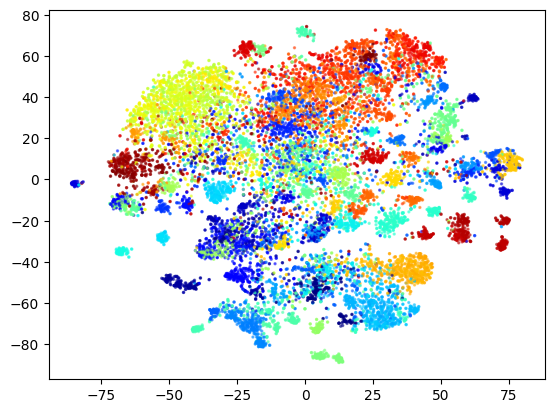

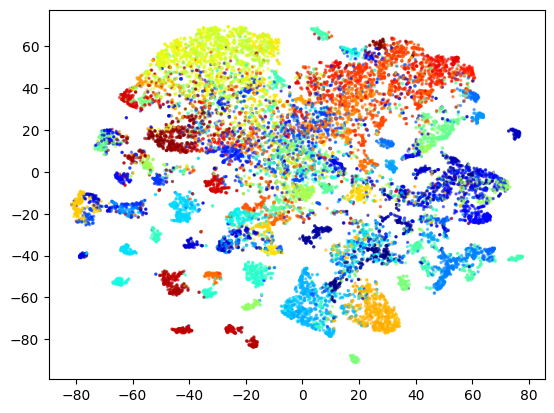

In [124]:
plt.scatter(X_f[:, 0], X_f[:, 1], c=labels[len(train_ds):], s=2, alpha=0.5, cmap='jet')
plt.show()

plt.scatter(X_s[:, 0], X_s[:, 1], c=labels[len(train_ds):], s=2, alpha=0.5, cmap='jet')
plt.show()

In [114]:
for i in range(len(history['mse1'])) :
    history['mse1'][i] = history['mse1'][i].detach().numpy()
    print(history['mse1'][i])

0.22383054
0.21534514
0.23283988
0.22143269
0.21760432
0.22035584
0.20802876
0.206018
0.2158123
0.22129323
0.21245487
0.22018653
0.21377315
0.23735642
0.22790696
0.22916882
0.21681632
0.23242572
0.21852687
0.23551644
0.22101647
0.23119374
0.21758999
0.22265537
0.21293518
0.22859468
0.21759224
0.22702405
0.23315437
0.22901271
0.21106796
0.21555625
0.22684437
0.23037739
0.21760398
0.22878793
0.21814214
0.22567657
0.22707172
0.22258312
0.22984679
0.22472878
0.21807048
0.2201836
0.22013344
0.23250149
0.22614346
0.22342914
0.2197973
0.22353566
0.22097047
0.21648094
0.23660031
0.2211736
0.2157431
0.21699399
0.21469276
0.22952366
0.22528543
0.22027011
0.22749133
0.21878703
0.23485641
0.22657596
0.21692733
0.2124012
0.22936256
0.22565411
0.21132329
0.22529827
0.22881356
0.21449329
0.22184372
0.22411731
0.20657471
0.21750882
0.22229107
0.22596887
0.22506969
0.22437362
0.22531506
0.2215475
0.22122224
0.21908718
0.21700013
0.21788158
0.22920673
0.21688691
0.23664014
0.20904776
0.21813919
0.225103

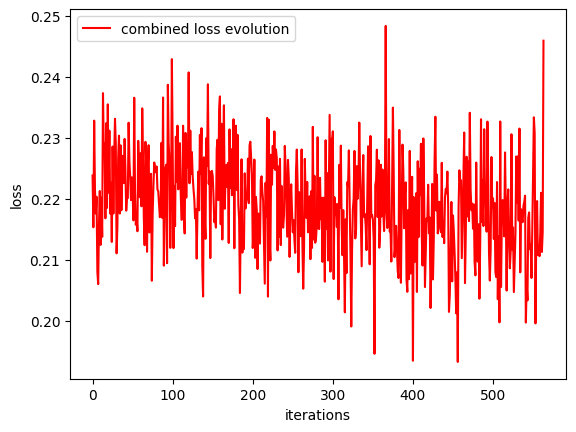

In [115]:
plt.plot(history['mse1'], label='combined loss evolution', c='r')
plt.legend()
plt.ylabel('loss')
plt.xlabel('iterations')
# plt.title('Epochs 5')
plt.show()